# Scratch Detection 

## Introduction:

In the semiconductor industry, **"wafers"** are thin discs of semiconductor material, such as silicon, used to fabricate microelectronic devices such as transistors, integrated circuits, and other components. A single wafer can contain hundreds or thousands of individual devices, known as **"dies"**, which are typically cut or "diced" from the wafer after the manufacturing process is completed.

You can read more about semiconductor here: <a href="https://web.archive.org/web/20230115132446/https://www.amd.com/en/technologies/introduction-to-semiconductors//">Introduction to Semiconductors</a>

<figure>
  <img src="assets/wafer.jpeg" width="350" height="280">
  <figcaption>Fig.1 - An example of a standard wafer</figcaption>
</figure>

One of the challenges in manufacturing wafers is to identify and isolate defects, including scratches, which can affect the performance and reliability of the resulting devices. 

Scratches are seen as elongated clusters of bad dies that have a high aspect ratio, meaning they are relatively thin and long compared to their width. They can be caused by equipment misalignment or mishandling by humans, and may contain latent defects that can affect the performance of the devices. Scratches may not always be continuous, so sometimes there may be good dies within the scratch. These good dies are often marked for removal in a manual process called "**Inked dies**" 

<figure>
  <img src="assets/scratch.png">
  <figcaption>Fig.2 - A scratch on a wafer - an optical view</figcaption>
</figure>

In the data that you receive, there may be faulty dies that are part of a scratch, which are labeled as "Scratch" as well as a few good dies that are part of a scratch, which are labeled as "Ink."

Many times, the Scratch Detection process will be done on the logical wafer map and not on a visual image of it.

The data that you received is called **"wafer map"** as it maps the status of all dies in the wafer.

The dies in the wafers are tested in a large number of stations, operations, and in each operation it is possible to create a map of the dies in this operation by coloring the good dies in a certain color and the faulty dies in another color.

<figure>
  <img src="assets/wafer_map.png" width="300" height="300">
  <figcaption>Fig.3 - A logical wafer map in a certain operation. good dies in green and bad dies in red</figcaption>
</figure>

Did you notice a scratch on this wafer?

Well, with our eyes it is easy to notice the scratch that comes out from the right side in the center of the wafer. 

Note, that this scratch is not continuous, meaning, not all the dies which are placed on this scratch are considered faults in this operation. We have to identify all scracthed dies including bad & good. The good dies that are part of the scartch have to be itendified actively in order to be killed. This process is called "inking". 

We kill them because we fear that a physical scratch on the silicon wafer is what caused the sequence of these faulty dies, therefore even dies that passed the tests may be of low quality because they were damaged by the scratch on which they are placed.

<figure>
  <img src="assets/wafer_map_with_marks.png" width="300" height="300">
  <figcaption>Fig.4 - A wafer map in a certain operation with scratch detection marks. good dies in grenn, bad dies in red, scratch in blue, ink in yellow</figcaption>
</figure>

You can read more about the causes of die failures here: <a href="https://semiengineering.com/why-chips-die//">Why Chips Die</a>

## Assignment description

In this assignment you are receiving wafer maps in a certain operation and the goal is to predict whether a given die belongs to scratch or not.

The data includes information about individual dies from a number of wafers.

The table data includes the following columns:

-  `WaferName` : The name of the wafer from which the die came.
- `DieX`: The horizontal position of the die on the wafer.
- `DieY`: The vertical position of the die on the wafer.
- `IsGoodDie`: A binary column indicating whether the die is good or not.
- `IsScratchDie`: A binary column indicating whether the die belongs to a scratch or not.

Your goal is to use the training data to build a model that can predict, given a certain wafer map, the dies on the map that are parts of a scratch (whether they are bad, 'Scratch' or good, 'Ink').

*The purpose of the assignment is mainly to get to reasonable solution that can help the business. Please note that real industry solutions usually achieve lower scores than you may be used from academic problems so even a low metric score on the test set may be considered a success*

Business goals:

- **Automation**. This process is currently a manual and expensive procedure that takes a lot of time and is prone to errors by the tagger. The goal is to perform this procedure in a faster time and save the costs of the test
- **Quality**. increasing the quality of the dies while balancing quality and yield (on the one hand, not to miss scratches, on the other hand not to do too much "Ink")
- **Prediction Level**. As explained above, the main goal is to detect individual dies, but sometimes it will help to also get a classification at the wafer level, (binary classification, is there a scratch on this wafer or not?) because there are manufacturers who return scratched wafers to the factory.

**Note**. In wafers with a low yield (that is, a lot of faulty dies), we will **not** perform scratch detection because the customer is afraid to find randomly generated scratches there and perform unnecessary ink. In such cases, the customer will make sure to check all the dies strictly in any case, but regardless of the detection of scratches. Therefore, in these cases we will not consider a sequence of bad die to be scratch. 

You are free to use any machine learning technique you find appropiate for solving this problem. Make sure choosing the relevamt metrics to test your solutions's performance.

In addition to the training data, you are given a test set, which includes the x and y coordinates and the good/not status of each die, but does not include the scratch/not scratch labels. 

You are asked to use your model to predict the scratch/not scratch status of the dies in the test set, and to save the predictions in a CSV file. You should submit your notebook including the experiments you did along the way to improve the model/various methods you tried and including your final model.

Pay attention to the following points:

- Exploratoration and analyze the data
- Consideration of business goals
- Selection of relevant machine learning models
- Appropriate choice of metrics

### Load Data

You can draw the wafers map to see how the wafers look like in the data. 

Using the following helper function you can draw the wafer maps with or without labels:

Select the amount of samples you want to display:

In [1]:
# n_samples = 4
# list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
# plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

In [2]:
# list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
# plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Wafer Scratch Detector

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import cv2
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from ultralytics import YOLO
from pathlib import Path

import torch
from skimage.morphology import skeletonize

from datetime import datetime
from random import sample


In [4]:
# --- PARAMETERS ---
OUTPUT_BASE = 'dataset'
MODEL_PATH = 'runs/segment/wafer_scratch_segmentation3/weights/best.pt'
INPUT_FOLDER = 'test_images'

# Preprocess

### data preprocessing and generation utils


In [5]:
# data preprocessing and generation
thickness_kernel_size = 3
img_size = 128

# --- FOLDER SETUP ---
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_BASE, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_BASE, 'labels', split), exist_ok=True)
    
# --- FUNCTIONS ---
def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
        
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height 
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()
    
def generate_wafer_image(wafer_name, df_wafers, display=False):
    """Generate RGB wafer image from data"""
    wafer_df = df_wafers[df_wafers['WaferName'] == wafer_name]
    width = wafer_df['DieX'].max() + 1
    height = wafer_df['DieY'].max() + 1
    wafer_img = np.full((height, width, 3), 255, dtype=np.uint8)

    for _, row in wafer_df.iterrows():
        x, y = row['DieX'], row['DieY']
        if not row['IsGoodDie']:
            wafer_img[y, x] = [255, 0, 0]  # Bad = red
        else:
            wafer_img[y, x] = [0, 255, 0]  # Good = green
            
    if display:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        plot_wafer_map(wafer_df, ax, 'Input')
        plt.show()

    return wafer_img

def get_wafer_dimensions(df_wafers, wafer_name):
    # Filter dataframe for the specified wafer
    wafer_df = df_wafers[df_wafers['WaferName'] == wafer_name]
    
    if wafer_df.empty:
        raise ValueError(f"Wafer '{wafer_name}' not found in the dataset")
    
    # Get the maximum x and y coordinates to determine width and height
    width = wafer_df['DieX'].max() + 1  # +1 because coordinates are 0-indexed
    height = wafer_df['DieY'].max() + 1  # +1 because coordinates are 0-indexed
    
    return width, height

def thicken_labeled_scratch(wafer_name, df_wafers, thickness_kernel_size=3, display=False):
    """Create binary mask for scratch pixels"""
    wafer_df = df_wafers[df_wafers['WaferName'] == wafer_name]
    width = wafer_df['DieX'].max() + 1
    height = wafer_df['DieY'].max() + 1
    mask = np.zeros((height, width), dtype=np.uint8)

    for _, row in wafer_df.iterrows():
        if row['IsScratchDie']:
            x, y = row['DieX'], row['DieY']
            mask[y, x] = 255

    kernel = np.ones((thickness_kernel_size, thickness_kernel_size), np.uint8)
    thickened_mask = cv2.dilate(mask, kernel, iterations=1)
    
    if display:
      fig, ax = plt.subplots(figsize=(6, 6))
      ax.set_aspect('equal')

      # Show the mask
      ax.imshow(thickened_mask, cmap='gray', origin='lower')

      # Define wafer center and radius
      center_x = width / 2
      center_y = height / 2
      radius = min(center_x, center_y) - 2  # subtract margin

      # Draw wafer edge as a dashed circle
      wafer_circle = plt.Circle((center_x, center_y), radius, color='cyan', fill=False, linewidth=2, linestyle='--')
      ax.add_patch(wafer_circle)

      # Force correct display range
      ax.set_xlim(0, width)
      ax.set_ylim(0, height)

      ax.set_title(f'Thickened Scratch Mask – {wafer_name}')
      ax.axis('off')
      plt.show()


    return thickened_mask

def create_yolo_seg_label(mask, label_path):
    """Convert binary mask to YOLO segmentation format"""
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Skip if no contours found
    if not contours:
        # Create empty label file
        with open(label_path, 'w') as f:
            pass
        return
    
    h, w = mask.shape
    
    with open(label_path, 'w') as f:
        for contour in contours:
            # Only include contours with reasonable size
            if cv2.contourArea(contour) > 5:  # Adjust threshold as needed
                # Class ID for 'scratch' is 0
                line = "0"
                
                # Normalize coordinates to 0-1 range and add to line
                for point in contour.reshape(-1, 2):
                    x, y = point
                    # Convert to YOLO format (normalized)
                    x_norm = x / w
                    y_norm = y / h
                    line += f" {x_norm:.6f} {y_norm:.6f}"
                
                f.write(line + '\n')

def save_wafer_and_label(wafer_name, df_wafers, split):
    """Save wafer image and corresponding YOLO segmentation label"""
    # Check if there's any scratch in this wafer
    wafer_data = df_wafers[df_wafers['WaferName'] == wafer_name]
    has_scratch = (wafer_data['IsScratchDie'] == True).any()
    
    # 1. Save wafer image (input)
    wafer_img = generate_wafer_image(wafer_name, df_wafers)
    # wafer_img = cv2.resize(wafer_img, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
    img_path = os.path.join(OUTPUT_BASE, 'images', split, f"{wafer_name}.png")
    cv2.imwrite(img_path, cv2.cvtColor(wafer_img, cv2.COLOR_RGB2BGR))

    # 2. Create and save YOLO segmentation label
    scratch_mask = thicken_labeled_scratch(wafer_name, df_wafers, thickness_kernel_size=thickness_kernel_size)
    scratch_mask = cv2.resize(scratch_mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
    
    # Save as TXT in YOLO segmentation format
    label_path = os.path.join(OUTPUT_BASE, 'labels', split, f"{wafer_name}.txt")
    create_yolo_seg_label(scratch_mask, label_path)
    
    # Save mask PNG for visualization (optional)
    vis_dir = os.path.join(OUTPUT_BASE, 'visualization', split)
    os.makedirs(vis_dir, exist_ok=True)
    mask_vis_path = os.path.join(vis_dir, f"{wafer_name}_mask.png")
    cv2.imwrite(mask_vis_path, scratch_mask)
    
    return has_scratch

def _generate_training_dataset(df_wafers, train_wafer_names, val_wafer_names):
    """Generate complete dataset with proper YOLO segmentation format"""
    print("Generating training set...")
    
    for wafer_name in tqdm(train_wafer_names, desc="Train wafers"):
        save_wafer_and_label(wafer_name, df_wafers, split='train')
        
    print(f"Training set generated complete")
    
    print("Generating validation set...")
    
    for wafer_name in tqdm(val_wafer_names, desc="Validation wafers"):
        save_wafer_and_label(wafer_name, df_wafers, split='val')
    
    print(f"Validation set generated complete")
    
def generate_training_dataset():
    #load zip file
    zf = zipfile.ZipFile('data.zip')

    #load train data
    df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
    
    # groupby WaferName and save all the different wafer names in a list
    wafer_names = df_wafers['WaferName'].unique().tolist()
        
    # Split into train/val
    wafer_names_train, wafer_names_val = train_test_split(
        wafer_names,
        test_size=0.1,
        random_state=42
    )

    print(f"Training set size: {len(wafer_names_train)}")
    print(f"Validation set size: {len(wafer_names_val)}")

    # Save to CSV
    train_df = pd.DataFrame(wafer_names_train, columns=['WaferName'])
    val_df = pd.DataFrame(wafer_names_val, columns=['WaferName'])

    # train_df.to_csv('wafer_names_train.csv', index=False)
    # val_df.to_csv('wafer_names_val.csv', index=False)

    # print("Wafer names saved to CSV!")
        
    # Generate the dataset
    _generate_training_dataset(df_wafers, train_df['WaferName'].tolist(), val_df['WaferName'].tolist())
        
def _generate_test_dataset(df_wafers_test):
    """Generate test dataset with predicted scratch labels"""
    
    # --- FOLDER SETUP ---
    os.makedirs(INPUT_FOLDER, exist_ok=True)
    
    print("Generating test dataset...")

    test_wafer_names = df_wafers_test['WaferName'].unique()

    # Wrap the loop in tqdm for a progress bar
    for wafer_name in tqdm(test_wafer_names, desc="Generating test images"):
        # Generate wafer image
        wafer_img = generate_wafer_image(wafer_name, df_wafers_test, display=False)
        
        # Save image for prediction
        img_path = os.path.join(INPUT_FOLDER, f"{wafer_name}.png")
        cv2.imwrite(img_path, cv2.cvtColor(wafer_img, cv2.COLOR_RGB2BGR))
        
        print("Test ataset generation complete!")      
               
def generate_test_dataset():
    #load zip file
    zf = zipfile.ZipFile('data.zip')

    #load test data
    df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
    
    # Generate the dataset
    _generate_test_dataset(df_wafers_test)
    

### Run preprocess and generation

In [6]:
GENERATE_TRAIN_DATASET = False
GENERATE_TEST_DATASET = False

if GENERATE_TRAIN_DATASET:
    generate_training_dataset()

if GENERATE_TEST_DATASET:
    generate_test_dataset()


# model training 


In [7]:
# model training 

# --- PARAMETERS ---
MODEL_NAME = 'yolo11n-seg.pt'
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 1  # Only one class: scratch
CLASS_NAME = 'scratch'

dataset_root = "C:/Users/ASUS/Downloads/scratch_detection_assignment/dataset"
NUM_CLASSES = 1 # Only one class: scratch
CLASS_NAME = "scratch"

# --- FUNCTIONS ---

def create_yaml_file():
    """
    Writes out a data_ready.yaml 
    """
    root = Path(dataset_root).resolve()
    # force forward-slashes even on Windows
    root_posix = root.as_posix()

    content = f"""\
# data_ready.yaml
# Absolute path to your dataset root (no leading slash on Windows)
path: {root_posix}

# Subfolders under `path/`
train: images/train
val:   images/val

# Number of classes
nc: {NUM_CLASSES}

# Class names
names:
  0: {CLASS_NAME}
"""
    yaml_path = Path("data_ready.yaml")
    yaml_path.write_text(content, encoding="utf-8", newline="\n")
    print(f"Wrote {yaml_path}\n")

def _train_model():
    """Train YOLO segmentation model with improved settings"""
    print("Starting model training...")
    
    # Load model
    model = YOLO(MODEL_NAME) 
    
    # Training arguments
    training_args = {
        'data': 'data_ready.yaml',
        'epochs': NUM_EPOCHS, 
        'patience': 50,  # Early stopping
        'imgsz': 128,
        'batch': BATCH_SIZE,
        'device': DEVICE,
        'name': 'wafer_scratch_segmentation',
        'save_period': 5,
        
        # Learning rate
        'lr0': 0.01,
        'lrf': 0.01,
    }
    
    # Train model
    results = model.train(**training_args)
    
    print("Training complete!")
    
    # Validate model
    print("Validating model...")
    model.val()
    
    print("Model validation complete!")
    
def train_model():
    create_yaml_file()
    _train_model()

### Run model training

In [8]:
TRAIN_MODEL = False
if TRAIN_MODEL:
    train_model()

# Data Testing and Evaluation

In [9]:
# data testing and evaluation

# --- FUNCTIONS ---
def predict_wafer(image_path, model_path, wafer_name, df_wafers, device='cpu', display=False):
    """
    Create a DataFrame that exactly matches the original wafer dimensions
    with a binary classifier for predicted scratches.
    
    Args:
        image_path: Path to the wafer image
        model_path: Path to the trained YOLO model
        wafer_name: Name of the wafer to process
        df_wafers: DataFrame containing original wafer data
    
    Returns:
        DataFrame with exactly the same number of pixels as the original wafer
    """
    # Get original wafer dimensions using DieX and DieY columns
    original_width, original_height = get_wafer_dimensions(df_wafers, wafer_name)
    
    # Load model
    model = YOLO(model_path)
    model = model.to(device=device)
    
    # Load image 
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get YOLO image dimensions
    yolo_height, yolo_width = img_rgb.shape[:2]
    print(f"YOLO image dimensions: {yolo_width}x{yolo_height}")
    
    # Predict scratch mask
    results = model.predict(image_path, imgsz=128, conf=0.25, iou=0.7, 
                           device=0 if torch.cuda.is_available() else 'cpu')
    
    # Get mask and resize to original wafer dimensions
    if results[0].masks is not None and len(results[0].masks.data) > 0:
        # extract the first predicted mask
        mask_pred = results[0].masks.data[0].cpu().numpy()
        # resize back to wafer dims
        mask_pred = cv2.resize(mask_pred,
                            (original_width, original_height),
                            interpolation=cv2.INTER_NEAREST)
        # skeletonize
        mask_thin = (skeletonize(mask_pred > 0).astype(np.uint8) * 255)
    else:
        print(f"No mask detected for wafer {wafer_name}")
        mask_pred = np.zeros((original_height, original_width), dtype=np.uint8)
        mask_thin = np.zeros((original_height, original_width), dtype=np.uint8)

    
    # Get the original wafer data for this specific wafer
    wafer_original_df = df_wafers[df_wafers['WaferName'] == wafer_name].copy()
    
    # Add IsScratchDie column based on the mask
    wafer_original_df['IsScratchDie'] = wafer_original_df.apply(
        lambda row: mask_thin[int(row['DieY']), int(row['DieX'])] > 0 
        if 0 <= int(row['DieY']) < original_height and 0 <= int(row['DieX']) < original_width else False,
        axis=1
    )
    if display:
        # Visualization
        fig, axs = plt.subplots(1, 3, figsize=(24, 8))
        
        # Create visualization image with original dimensions
        vis_img = np.zeros((original_height, original_width, 3), dtype=np.uint8)
        for _, row in wafer_original_df.iterrows():
            x, y = int(row['DieX']), int(row['DieY'])
            vis_img[y, x] = [255, 255, 255]  # White pixel for wafer area
        
        # Original wafer shape
        axs[0].imshow(vis_img)
        axs[0].set_title(f'Original Wafer Shape: {original_width}x{original_height}')
        axs[0].axis('off')
        
        # Segmentation mask
        mask_vis = np.zeros((original_height, original_width, 3), dtype=np.uint8)
        mask_vis[mask_pred > 0] = [0, 255, 0]  # Green for the mask
        axs[1].imshow(mask_vis)
        axs[1].set_title('Segmentation Mask (Resized to Original Dimensions)')
        axs[1].axis('off')
        
        # Original with scratch overlay
        scratch_vis = vis_img.copy()
        scratch_df = wafer_original_df[wafer_original_df['IsScratchDie']]
        for _, row in scratch_df.iterrows():
            x, y = int(row['DieX']), int(row['DieY'])
            scratch_vis[y, x] = [255, 0, 255]  # Magenta for scratches
        
        axs[2].imshow(scratch_vis)
        axs[2].set_title('Wafer with Predicted Scratch Pixels (Magenta)')
        axs[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"Original wafer dimensions: {original_width}x{original_height} ({original_width*original_height} total pixels)")
        print(f"DataFrame contains {len(wafer_original_df)} pixels")
        print(f"- {scratch_df.shape[0]} are predicted scratch pixels")
        
        # Display first few rows
        print("\nSample of DataFrame:")
        print(wafer_original_df.head(10))
        
        # Display stats
        print("\nPixel statistics:")
        print(wafer_original_df['IsScratchDie'].value_counts())
    
    return wafer_original_df

def predict_test_wafers(df_wafers_test):
        
    failures = 0
    df_list  = []

    # Collect only PNGs
    png_files = [f for f in os.listdir(INPUT_FOLDER) if f.endswith('.png')]

    # --- Iterate & predict ---
    for img_file in tqdm(png_files, desc="Predicting test wafers"):
        wafer_name = img_file[:-4]
        img_path   = os.path.join(INPUT_FOLDER, img_file)

        df_wafer = predict_wafer(
            image_path=img_path,
            model_path=MODEL_PATH,
            wafer_name=wafer_name,
            df_wafers=df_wafers_test,
            device='cpu'
        )
        if df_wafer is None:
            failures += 1
            continue

        df_list.append(df_wafer)

    total = len(png_files)
    print(f"Wafers with no mask detected: {failures}/{total} ({failures/total:.1%})")

    df_preds = pd.concat(df_list, ignore_index=True)

    # Rename the column so it matches your test DF
    # df_preds = df_preds.rename(columns={'predictedScratch':'IsScratchDie'})

    # --- Merge back onto original test set ---
    # Drop any old column
    if 'IsScratchDie' in df_wafers_test.columns:
        df_wafers_test = df_wafers_test.drop(columns='IsScratchDie')

    df_merged = df_wafers_test.merge(
        df_preds[['WaferName','DieX','DieY','IsScratchDie']],
        on=['WaferName','DieX','DieY'],
        how='left'
    )

    # Fill dies with no prediction as False
    df_merged['IsScratchDie'] = df_merged['IsScratchDie'].fillna(False).astype(bool)

    df_wafers_test = df_merged.copy()
    
    return df_wafers_test

def evaluate_model():
    #load test data
    zf = zipfile.ZipFile('data.zip')
    
    df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))

    df_wafers_test_predictions = predict_test_wafers(df_wafers_test)
    clear_scratch_on_low_yield(df_wafers_test_predictions, yield_threshold=0.85, good_col='IsGoodDie', scratch_col='IsScratchDie')
    df_wafers_test_predictions.to_csv('wafers_test_predictions.csv', index=False)
    print("Predictions saved to CSV!")
    
def clear_scratch_on_low_yield(
    df: pd.DataFrame,
    yield_threshold: float = 0.85,
    good_col: str = 'IsGoodDie',
    scratch_col: str = 'IsScratchDie',
) -> pd.DataFrame:
    """
    For any wafer whose yield (mean of good_col) is below yield_threshold,
    set all values in scratch_col to False.
    """
    df2 = df.copy()
    # 1) compute per-wafer yield
    yields = df2.groupby('WaferName')[good_col].mean()
    # 2) find the wafers we want to “clear”
    low_yield_wafers = yields[yields < yield_threshold].index
    # 3) zero out just that column on those wafers
    df2.loc[df2['WaferName'].isin(low_yield_wafers), scratch_col] = False
    return df2



### Run Model Evaluation

In [10]:
EVAL_MODEL = False

if EVAL_MODEL:
    evaluate_model()

### Run Display Results

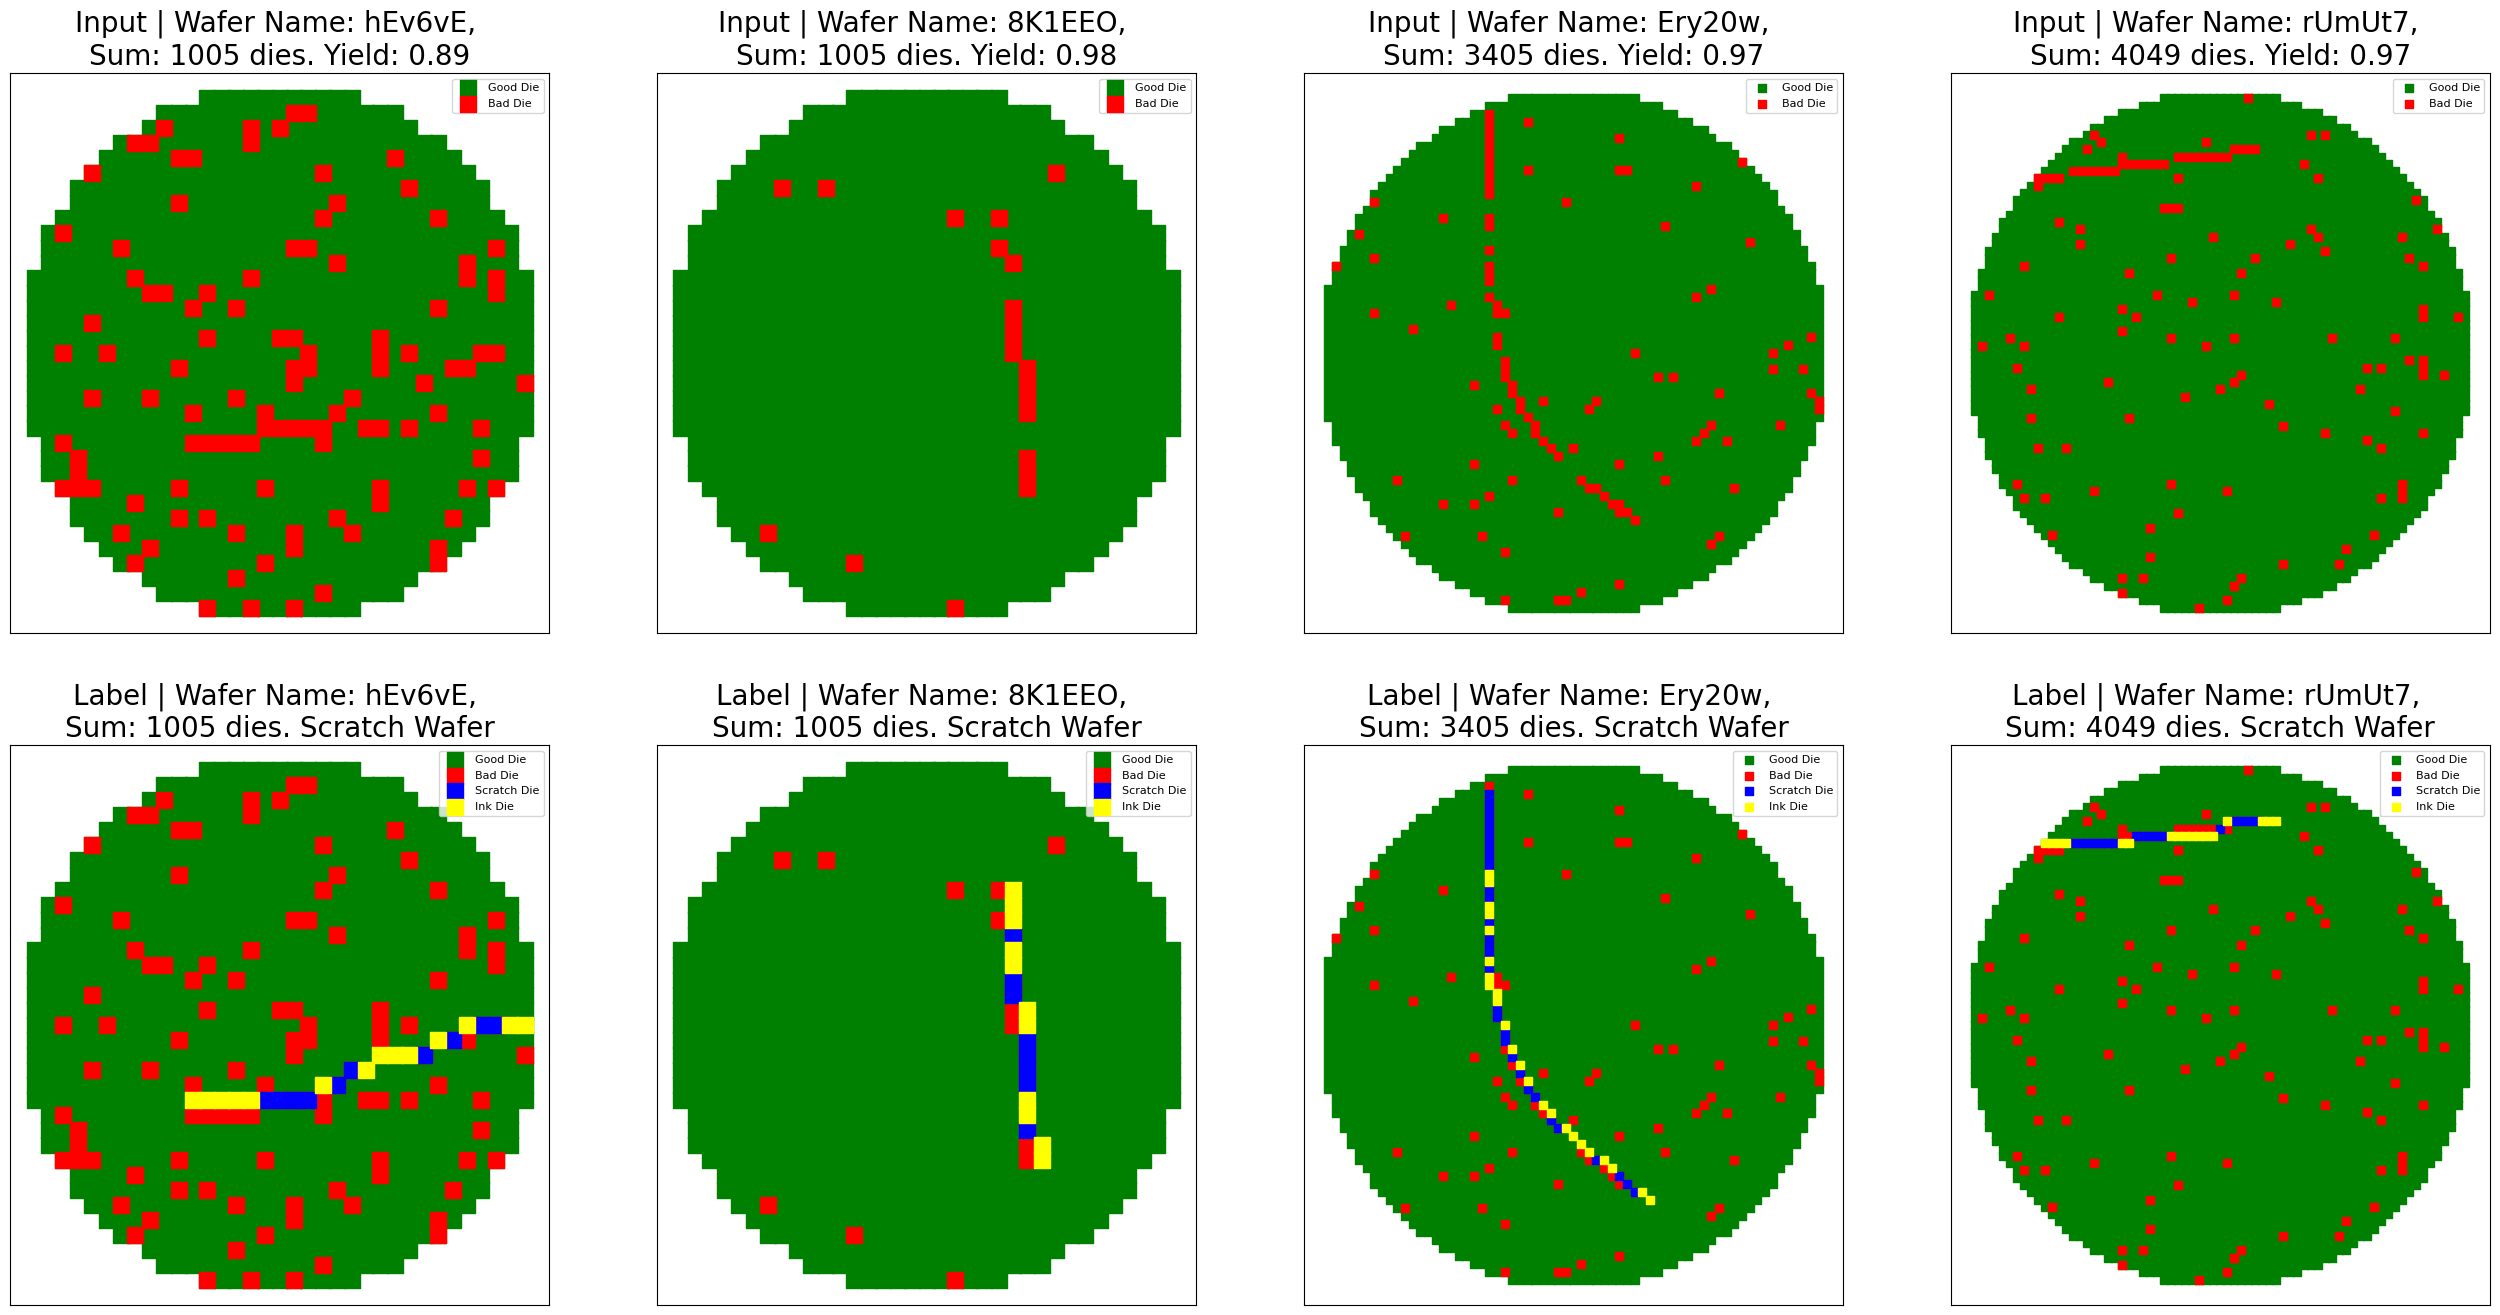

In [11]:
n_samples = 4
df_wafers_test_pred = pd.read_csv('wafers_test_predictions.csv')
list_sample_test = [df_wafers_test_pred.groupby('WaferName').get_group(group) for group in df_wafers_test_pred['WaferName'].value_counts().sample(n_samples, random_state=76).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = True)

# Additional thoughts

**My approach**  

- **Scoping the data**: I first verified the amount of training data to understand if I have enough samples for training a good DL model. 

- **Classic CV experiments**: Even though i thought i have enough I looked into the literature and  implemented a classic Hough‐line transforms to catch linear scratches, but eventually because they were not detecting  irregular scratch shapes and overall produced poor results.  

- **CNN classifier prototype**: To validate whether wafers contained scratches at all, I trained a simple CNN for binary wafer-level classification, achieving good accuracy. This confirmed the data was learnable, but lacked any pixel-level localization needed for segmentation.   

- **Adopting YOLOv8-Seg**: Switching to YOLOv11’s segmentation model, I encountered a few adaptation problems, traditional YOLO is designed to detect objects, not isolated pixels. To solve this i “thickened” each ground-truth scratch pixel into a small patch—giving the model a volumetric target to learn.

- **Post-processing with skeletonization**: After inference, I  applied on the predicted masks a skeletonize step to collapse thick patches back into single-pixel lines—recovering precise scratch paths.  

- **Validation & Results**: On the validation set I reached ~96% precision (few false alarms) but only ~71% recall, mainly because the model was struggling with the exact pixel identification.

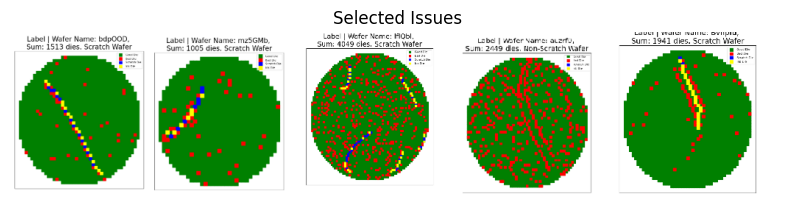

In [12]:
# display selected issues 
image_path = 'selected_issues_images.png'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Selected Issues')
plt.show()

### Selected issues
1. The model picks up the main line, but adjacent faulty dies aren’t included in the segmentation.
2. Skeletonization reduces  broad scratches to a single‐pixel line, dropping portions of the defect.
3. Faulty wafers (but still >85%) produce many false‐positive "scratches".
4. Wafers with yields ~80–85% get entirely cleared of scratch labels, even when clear defects exist.
5. When two scartches run near each other, thickening + skeletonization causes the scratch to be identifyed between them, where there probably no issue.

### Model improvement ideas
1. Adding an hyper parameter for the thickening and skeletonizing of the scratch.
2. Instead of a hard yield cutoff, incorporate a confidence‐based gating step.
3. Train a larger model, for longer, with more data.